In [1]:
from preprocessing import load_reviews
from experiments import run_experiment
from features import SentimentFeatures
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
import random

[nltk_data] Downloading package punkt to /home/janek/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2025-11-28 15:23:35.813325: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Setup

In [2]:
seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
train_df, test_df, val_df = load_reviews("word", seed)

## Loading IMDb Reviews Dataset

I0000 00:00:1764339818.002242    2493 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-11-28 15:23:38.267680: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-11-28 15:23:42.082184: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-28 15:23:46.106241: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**Total reviews before deduplication:** 50000

**Total reviews after deduplication:** 49582

**Train / Validation / Test sizes:**

,split,count
0,train,29749
1,val,9916
2,test,9917


### Sample Reviews

**Train Set:**

,review,sentiment,units
19067,As with all environmentally aware films from t...,1,"[as, with, all, environmentally, aware, films,..."
33476,I completely understand the historical signifi...,0,"[i, completely, understand, the, historical, s..."
26034,First of all this is one of the worst soft-cor...,0,"[first, of, all, this, is, one, of, the, worst..."
42039,"Some weeks ago, at a movie theater, I saw a mo...",0,"[some, weeks, ago, at, a, movie, theater, i, s..."
20837,As someone who has seen and followed Hartley's...,1,"[as, someone, who, has, seen, and, followed, h..."


**Test Set:**

,review,sentiment,units
6092,This movie is an idiotic attempt at some kind ...,0,"[this, movie, is, an, idiotic, attempt, at, so..."
23020,ANCHORS AWEIGH is an entertaining MGM musical ...,1,"[anchors, aweigh, is, an, entertaining, mgm, m..."
13778,One of the best movies I ever saw was an Irish...,1,"[one, of, the, best, movies, i, ever, saw, was..."
16434,We saw this at one of the local art movie thea...,1,"[we, saw, this, at, one, of, the, local, art, ..."
4218,I am compelled to write a review of this IMAX ...,0,"[i, am, compelled, to, write, a, review, of, t..."


**Validation Set:**

,review,sentiment,units
8437,Style but no substance. Not as funny as it sho...,0,"[style, but, no, substance, not, as, funny, as..."
43138,"Not well done at all, the whole movie was just...",0,"[not, well, done, at, all, the, whole, movie, ..."
45198,I am really sad that that this film has got so...,1,"[i, am, really, sad, that, that, this, film, h..."
20751,This is one of my favorite family movies. Love...,1,"[this, is, one, of, my, favorite, family, movi..."
45035,"When I first saw this movie, I said to myself,...",0,"[when, i, first, saw, this, movie, i, said, to..."


In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['units'])

train_df["concept_ids"] = tokenizer.texts_to_sequences(train_df['units'])
test_df["concept_ids"] = tokenizer.texts_to_sequences(test_df['units'])

In [5]:
# Number of unique tokens in the tokenizer
num_unique_tokens = len(tokenizer.word_index)  # word_index maps token -> unique ID
print("Number of unique tokens:", num_unique_tokens)
train_df.head()

Number of unique tokens: 81890


,review,sentiment,units,concept_ids
19067,As with all environmentally aware films from t...,1,"[as, with, all, environmentally, aware, films,...","[14, 16, 29, 34992, 1875, 105, 35, 1, 21, 1064..."
33476,I completely understand the historical signifi...,0,"[i, completely, understand, the, historical, s...","[9, 320, 369, 1, 1302, 5144, 4, 24271, 1527, 1..."
26034,First of all this is one of the worst soft-cor...,0,"[first, of, all, this, is, one, of, the, worst...","[89, 4, 29, 10, 5, 27, 4, 1, 241, 1704, 1764, ..."
42039,"Some weeks ago, at a movie theater, I saw a mo...",0,"[some, weeks, ago, at, a, movie, theater, i, s...","[48, 2224, 571, 30, 3, 15, 719, 9, 204, 3, 15,..."
20837,As someone who has seen and followed Hartley's...,1,"[as, someone, who, has, seen, and, followed, h...","[14, 273, 33, 46, 109, 2, 1571, 4634, 21, 999,..."


# Feature selection

In [6]:
an = SentimentFeatures()
an.fit(train_df["concept_ids"], train_df["sentiment"])

In [7]:
num_important_features = int(num_unique_tokens * 0.2)
train_df = an.add_top_features(train_df, n=num_important_features)
test_df  = an.add_top_features(test_df, n=num_important_features)

# Models

In [8]:
train_df.head()

,review,sentiment,units,concept_ids,concept_ids_positive_features,concept_ids_negative_features,concept_ids_important_features
19067,As with all environmentally aware films from t...,1,"[as, with, all, environmentally, aware, films,...","[14, 16, 29, 34992, 1875, 105, 35, 1, 21, 1064...","[14, 16, 1875, 105, 35, 1, 21, 10648, 46, 3, 6...","[29, 244, 908, 47, 17786, 38, 98, 84, 6, 5143,...","[14, 16, 29, 1875, 105, 35, 1, 21, 10648, 46, ..."
33476,I completely understand the historical signifi...,0,"[i, completely, understand, the, historical, s...","[9, 320, 369, 1, 1302, 5144, 4, 24271, 1527, 1...","[1, 1302, 5144, 4, 1527, 3, 16, 1, 5, 4, 5, 2,...","[9, 320, 369, 24271, 1394, 18, 11, 74, 12, 95,...","[9, 320, 369, 1, 1302, 5144, 4, 24271, 1527, 1..."
26034,First of all this is one of the worst soft-cor...,0,"[first, of, all, this, is, one, of, the, worst...","[89, 4, 29, 10, 5, 27, 4, 1, 241, 1704, 1764, ...","[89, 4, 5, 27, 4, 1, 679, 8, 59, 111, 4, 256, ...","[29, 10, 241, 1704, 688, 6, 9, 24, 122, 37, 29...","[89, 4, 29, 10, 5, 27, 4, 1, 241, 1704, 688, 6..."
42039,"Some weeks ago, at a movie theater, I saw a mo...",0,"[some, weeks, ago, at, a, movie, theater, i, s...","[48, 2224, 571, 30, 3, 15, 719, 9, 204, 3, 15,...","[2224, 571, 3, 204, 3, 4, 4181, 19450, 16, 1, ...","[48, 30, 15, 719, 9, 15, 3216, 88, 852, 24, 9,...","[48, 2224, 571, 30, 3, 15, 719, 9, 204, 3, 15,..."
20837,As someone who has seen and followed Hartley's...,1,"[as, someone, who, has, seen, and, followed, h...","[14, 273, 33, 46, 109, 2, 1571, 4634, 21, 999,...","[14, 33, 46, 2, 4634, 21, 999, 158, 17, 421, 1...","[273, 9, 76, 47, 317, 6, 28, 142, 83, 86, 3991...","[14, 273, 33, 46, 2, 4634, 21, 999, 158, 17, 4..."


# TF-IDF

In [9]:
y_train = train_df["sentiment"]
y_test = test_df["sentiment"]

In [10]:
train_df["concept_ids"] = train_df["concept_ids"].apply(
    lambda x: " ".join(str(id) for id in x)
)
train_df.head()

train_df["concept_ids_positive_features"] = train_df["concept_ids_positive_features"].apply(
    lambda x: " ".join(str(id) for id in x)
)
train_df.head()

train_df["concept_ids_negative_features"] = train_df["concept_ids_negative_features"].apply(
    lambda x: " ".join(str(id) for id in x)
)
train_df.head()

train_df["concept_ids_important_features"] = train_df["concept_ids_important_features"].apply(
    lambda x: " ".join(str(id) for id in x)
)
train_df.head()

,review,sentiment,units,concept_ids,concept_ids_positive_features,concept_ids_negative_features,concept_ids_important_features
19067,As with all environmentally aware films from t...,1,"[as, with, all, environmentally, aware, films,...",14 16 29 34992 1875 105 35 1 21 10648 1464 46 ...,14 16 1875 105 35 1 21 10648 46 3 614 4 5 2426...,29 244 908 47 17786 38 98 84 6 5143 9 13 1401 ...,14 16 29 1875 105 35 1 21 10648 46 3 244 908 6...
33476,I completely understand the historical signifi...,0,"[i, completely, understand, the, historical, s...",9 320 369 1 1302 5144 4 24271 1527 1394 18 11 ...,1 1302 5144 4 1527 3 16 1 5 4 5 2 5251 17 1 25...,9 320 369 24271 1394 18 11 74 12 95 7 15 6 834...,9 320 369 1 1302 5144 4 24271 1527 1394 18 11 ...
26034,First of all this is one of the worst soft-cor...,0,"[first, of, all, this, is, one, of, the, worst...",89 4 29 10 5 27 4 1 241 1704 1764 688 6 1866 2...,89 4 5 27 4 1 679 8 59 111 4 256 3142 5 3 1356...,29 10 241 1704 688 6 9 24 122 37 29 22 171 6 4...,89 4 29 10 5 27 4 1 241 1704 688 6 679 9 24 12...
42039,"Some weeks ago, at a movie theater, I saw a mo...",0,"[some, weeks, ago, at, a, movie, theater, i, s...",48 2224 571 30 3 15 719 9 204 3 15 3216 4 4181...,2224 571 3 204 3 4 4181 19450 16 1 3504 1 71 4...,48 30 15 719 9 15 3216 88 852 24 9 186 41 77 2...,48 2224 571 30 3 15 719 9 204 3 15 3216 4 4181...
20837,As someone who has seen and followed Hartley's...,1,"[as, someone, who, has, seen, and, followed, h...",14 273 33 46 109 2 1571 4634 21 999 158 17 421...,14 33 46 2 4634 21 999 158 17 421 152 103 4 11...,273 9 76 47 317 6 28 142 83 86 3991 155 2424 3...,14 273 33 46 2 4634 21 999 158 17 421 152 9 10...


In [11]:
test_df["concept_ids"] = test_df["concept_ids"].apply(
    lambda x: " ".join(str(id) for id in x)
)
test_df.head()

test_df["concept_ids_positive_features"] = test_df["concept_ids_positive_features"].apply(
    lambda x: " ".join(str(id) for id in x)
)
test_df.head()

test_df["concept_ids_negative_features"] = test_df["concept_ids_negative_features"].apply(
    lambda x: " ".join(str(id) for id in x)
)
test_df.head()

test_df["concept_ids_important_features"] = test_df["concept_ids_important_features"].apply(
    lambda x: " ".join(str(id) for id in x)
)
test_df.head()

,review,sentiment,units,concept_ids,concept_ids_positive_features,concept_ids_negative_features,concept_ids_important_features
6092,This movie is an idiotic attempt at some kind ...,0,"[this, movie, is, an, idiotic, attempt, at, so...",10 15 5 34 3191 543 30 48 217 4 198 679 3 3022...,5 34 4 679 3 3022 94 5 32 3 4 1 2 4 66 1 1243 ...,10 15 3191 543 30 48 217 2620 23 96 6 5410 393...,10 15 5 34 3191 543 30 48 217 4 679 3 3022 262...
23020,ANCHORS AWEIGH is an entertaining MGM musical ...,1,"[anchors, aweigh, is, an, entertaining, mgm, m...",9917 11411 5 34 425 2783 658 11 445 4 1 484 55...,9917 11411 5 34 425 2783 658 445 4 1 484 55 33...,11 18 9 49 12 7 56 38 37 39 10 13 11 1474 23 2...,9917 11411 5 34 425 2783 658 11 445 4 1 484 55...
13778,One of the best movies I ever saw was an Irish...,1,"[one, of, the, best, movies, i, ever, saw, was...",27 4 1 117 99 9 122 204 13 34 2295 15 3694 779...,27 4 1 117 204 34 2295 7797 1 275 160 204 1 2 ...,99 9 122 13 15 3694 128 9 208 9 322 9 15 91 7 ...,27 4 1 117 99 9 122 204 13 34 2295 15 3694 779...
16434,We saw this at one of the local art movie thea...,1,"[we, saw, this, at, one, of, the, local, art, ...",71 204 10 30 27 4 1 683 476 15 2140 8 1 17509 ...,71 204 27 4 1 476 8 1 17509 4 9336 3 828 1 8 1...,10 30 15 24082 7 13 923 6 893 56 719 18 68 230...,71 204 10 30 27 4 1 476 15 8 1 17509 4 9336 24...
4218,I am compelled to write a review of this IMAX ...,0,"[i, am, compelled, to, write, a, review, of, t...",9 97 5414 6 893 3 705 4 10 13281 744 14 3 777 ...,3 4 13281 744 14 3 777 4 388 382 4 13890 4619 ...,9 97 5414 6 893 705 10 1641 6 593 125 287 101 ...,9 97 5414 6 893 3 705 4 10 13281 744 14 3 777 ...


In [12]:
# Main concept IDs
tfidf_main = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), min_df=2, max_df=0.8)
X_all_train = tfidf_main.fit_transform(train_df["concept_ids"])
X_all_test  = tfidf_main.transform(test_df["concept_ids"])

# Positive features
tfidf_pos = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), min_df=2, max_df=0.8)
X_pos_train = tfidf_pos.fit_transform(train_df["concept_ids_positive_features"])
X_pos_test  = tfidf_pos.transform(test_df["concept_ids_positive_features"])

# Negative features
tfidf_neg = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), min_df=2, max_df=0.8)
X_neg_train = tfidf_neg.fit_transform(train_df["concept_ids_negative_features"])
X_neg_test  = tfidf_neg.transform(test_df["concept_ids_negative_features"])

# Important features
tfidf_imp = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), min_df=2, max_df=0.8)
X_imp_train = tfidf_neg.fit_transform(train_df["concept_ids_important_features"])
X_imp_test = tfidf_neg.transform(test_df["concept_ids_important_features"])

In [13]:
# Prepare data in the required dictionary format
X_sets_train = {
    'all': X_all_train,
    'pos': X_pos_train, 
    'neg': X_neg_train,
    'important': X_imp_train
}

X_sets_test = {
    'all': X_all_test,
    'pos': X_pos_test,
    'neg': X_neg_test,
    'important': X_imp_test
}

# Verify shapes
print("\nData shapes:")
for key in X_sets_train:
    print(f"Train {key}: {X_sets_train[key].shape}")
for key in X_sets_test:
    print(f"Test {key}: {X_sets_test[key].shape}")

print(f"\nLabel shapes: y_train {y_train.shape}, y_test {y_test.shape}")


Data shapes:
Train all: (29749, 50000)
Train pos: (29749, 50000)
Train neg: (29749, 50000)
Train important: (29749, 50000)
Test all: (9917, 50000)
Test pos: (9917, 50000)
Test neg: (9917, 50000)
Test important: (9917, 50000)

Label shapes: y_train (29749,), y_test (9917,)


## Linear-SVM

LinearSVM 'all' initialized with C=1.0
LinearSVM 'all' trained.


## ALL Evaluation

**Accuracy:** 0.9959

,precision,recall,f1-score,support
0,0.99588,0.99595,0.99592,14819
1,0.99598,0.99591,0.99595,14930
accuracy,0.99593,0.99593,0.99593,0
macro avg,0.99593,0.99593,0.99593,29749
weighted avg,0.99593,0.99593,0.99593,29749


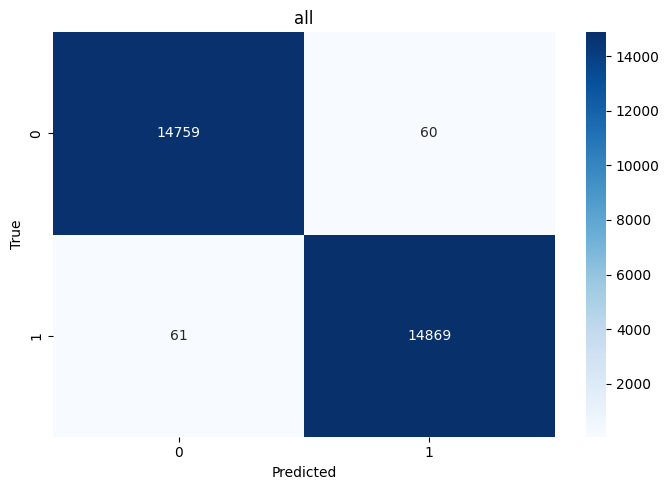

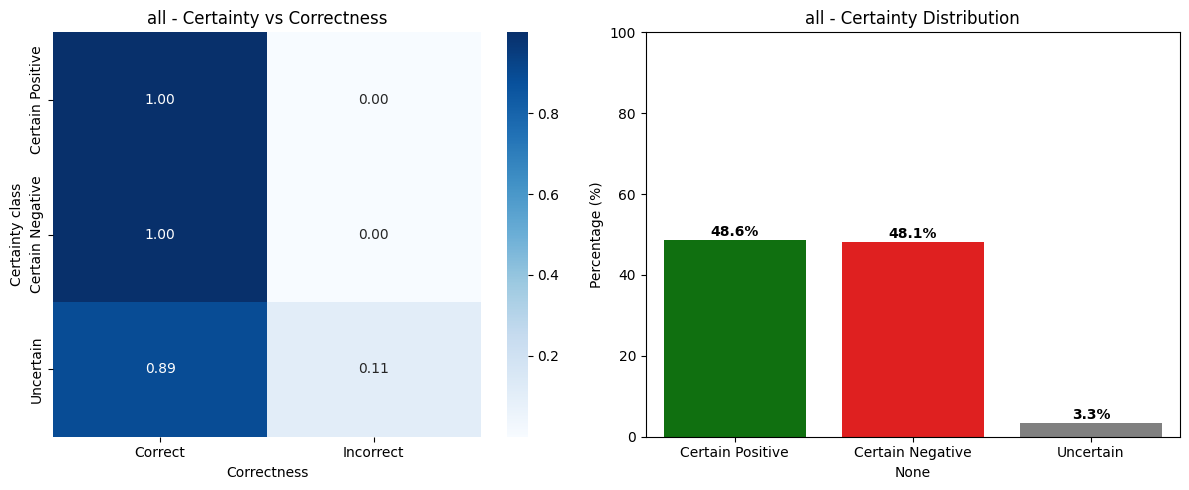

## ALL Model — Unsure Predictions

,probability,true_label,text
0,0.6828,1,This film is about a bunch of misfits who are ...
1,0.3648,0,"this movie, i won't call it a ""film,"" was basi..."
2,0.6446,1,"I'm not here to tell you ""Armored"" is Kubricki..."
3,0.6957,1,The various Law & Order and CSI franchises had...
4,0.5626,1,when i saw the movie at first i thought that i...


## ALL Model — Misclassified Predictions

,probability,true_label,predicted,text
0,0.4539,1,0,"I read Angels and Demons about 3 years ago, an..."
1,0.4942,1,0,A fey story of a Martian attempt to colonize E...
2,0.3856,1,0,Forget everything that you have ever read abou...
3,0.5909,0,1,I enjoyed the beautiful scenery in this movie ...
4,0.7212,0,1,"Based on the comments made so far, everyone se..."


LinearSVM 'pos' initialized with C=1.0
LinearSVM 'pos' trained.


## POS Evaluation

**Accuracy:** 0.9830

,precision,recall,f1-score,support
0,0.98345,0.98245,0.98295,14819
1,0.98260,0.98359,0.98310,14930
accuracy,0.98302,0.98302,0.98302,0
macro avg,0.98303,0.98302,0.98302,29749
weighted avg,0.98303,0.98302,0.98302,29749


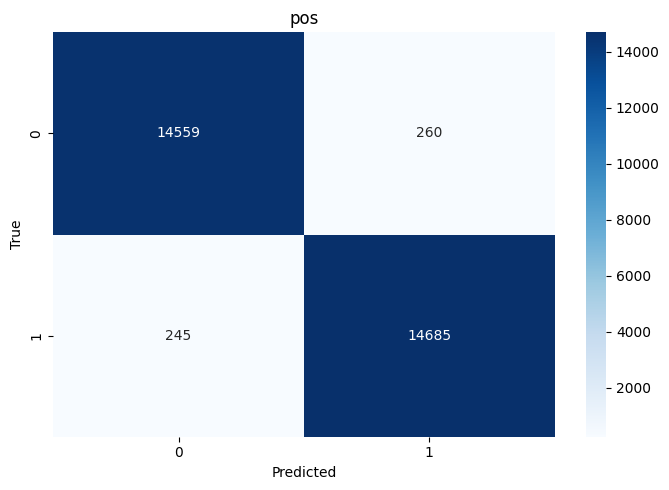

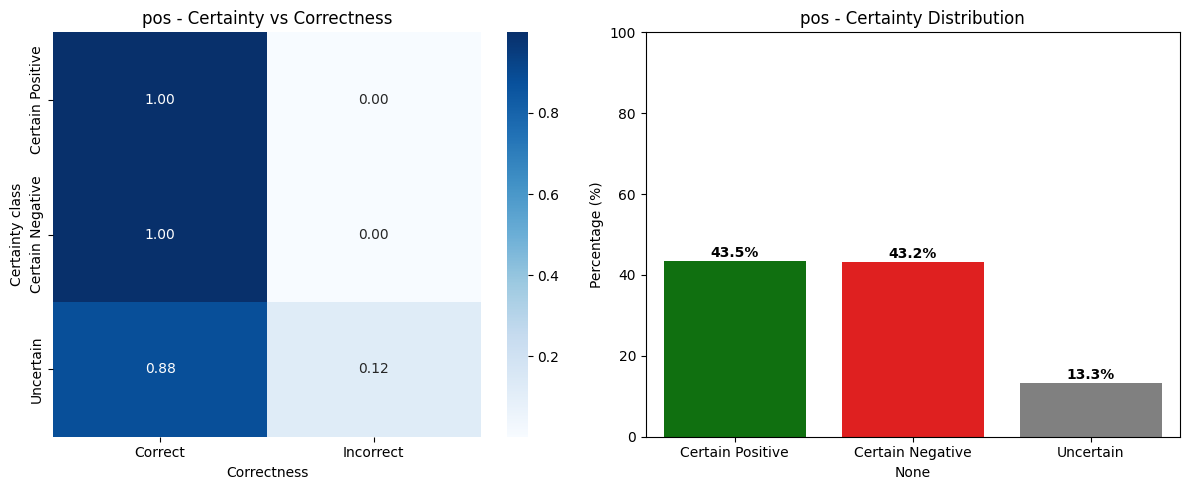

## POS Model — Unsure Predictions

,probability,true_label,text
0,0.6897,1,As someone who has seen and followed Hartley's...
1,0.4795,0,who reads these comments may think we may have...
2,0.3965,0,NBC had a chance to make a powerful religious ...
3,0.5786,1,This film is shockingly underrated on IMDb. Li...
4,0.6538,1,After a very long time Marathi cinema has come...


## POS Model — Misclassified Predictions

,probability,true_label,predicted,text
0,0.5315,0,1,I went to see this movie at our college theate...
1,0.5328,0,1,I'm not surprised that this film did well at t...
2,0.4507,1,0,when i saw the movie at first i thought that i...
3,0.4179,1,0,I had watched several days film shooting of th...
4,0.5371,0,1,I'll bet none of you knew that the famous Conq...


LinearSVM 'neg' initialized with C=1.0
LinearSVM 'neg' trained.


## NEG Evaluation

**Accuracy:** 0.9915

,precision,recall,f1-score,support
0,0.99143,0.99156,0.99150,14819
1,0.99163,0.99149,0.99156,14930
accuracy,0.99153,0.99153,0.99153,0
macro avg,0.99153,0.99153,0.99153,29749
weighted avg,0.99153,0.99153,0.99153,29749


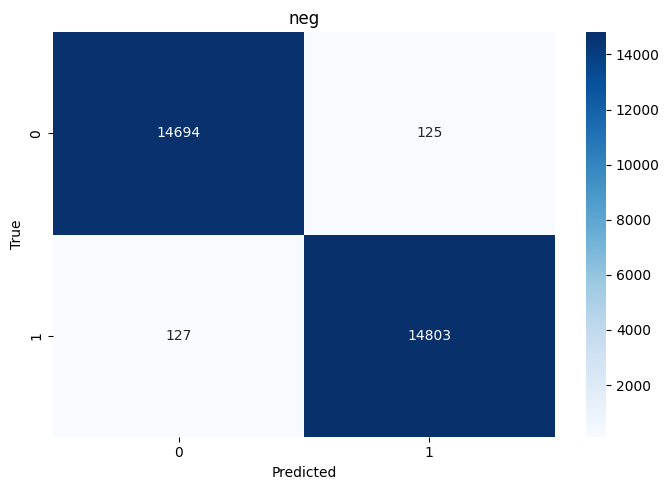

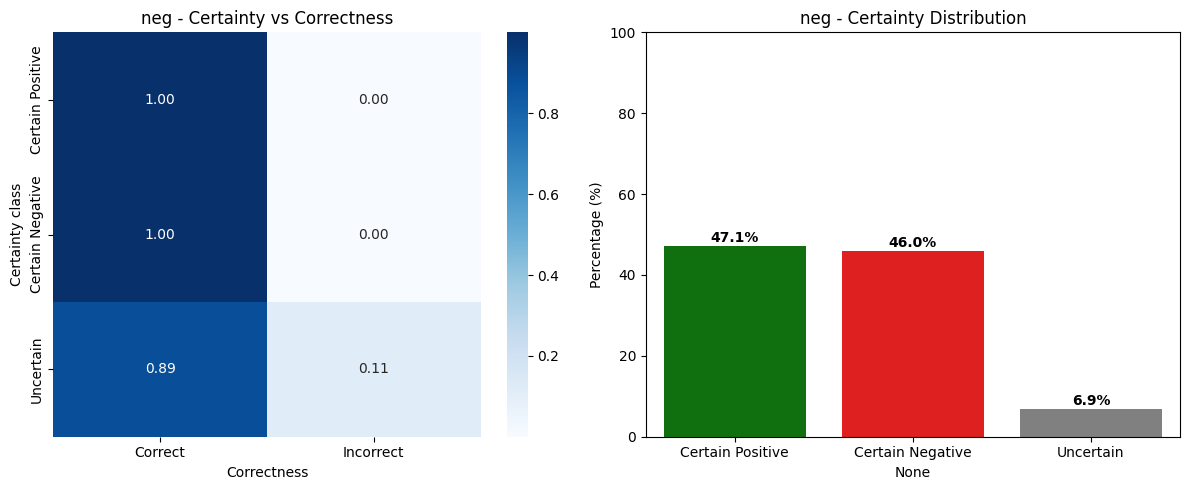

## NEG Model — Unsure Predictions

,probability,true_label,text
0,0.3323,0,This movie and several other movies from the 1...
1,0.6600,1,This film is shockingly underrated on IMDb. Li...
2,0.3050,0,"This movie is great, mind you - but only in th..."
3,0.3988,0,Hollywood Hotel was the last movie musical tha...
4,0.3389,0,I agree that Mary Woronov (Murdoch's secretary...


## NEG Model — Misclassified Predictions

,probability,true_label,predicted,text
0,0.3704,1,0,"Late, great Grade Z drive-in exploitation film..."
1,0.7248,0,1,This movie wasn't too funny. It wasn't too hor...
2,0.4852,1,0,"Infamous pre-code film, really the one film th..."
3,0.4528,1,0,"Despite of the success in comedy or drama, the..."
4,0.4166,1,0,Forget everything that you have ever read abou...


LinearSVM 'important' initialized with C=1.0
LinearSVM 'important' trained.


## IMPORTANT Evaluation

**Accuracy:** 0.9955

,precision,recall,f1-score,support
0,0.99595,0.99507,0.99551,14819
1,0.99511,0.99598,0.99555,14930
accuracy,0.99553,0.99553,0.99553,0
macro avg,0.99553,0.99553,0.99553,29749
weighted avg,0.99553,0.99553,0.99553,29749


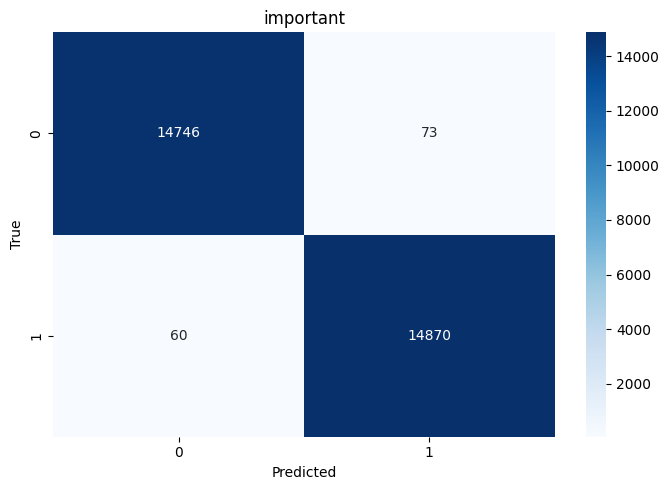

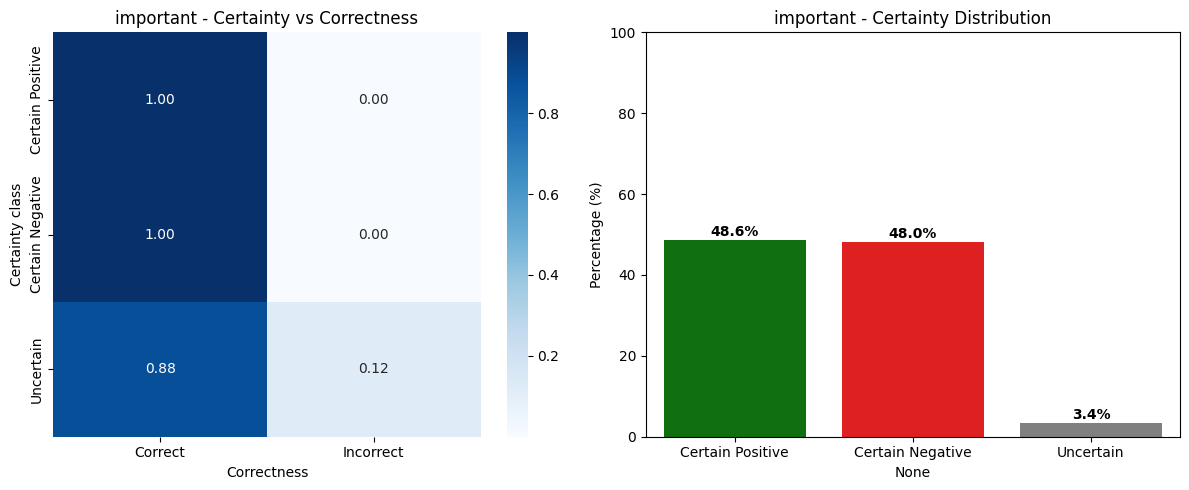

## IMPORTANT Model — Unsure Predictions

,probability,true_label,text
0,0.6433,1,This film is shockingly underrated on IMDb. Li...
1,0.3284,0,"this movie, i won't call it a ""film,"" was basi..."
2,0.6205,1,"I'm not here to tell you ""Armored"" is Kubricki..."
3,0.5726,1,when i saw the movie at first i thought that i...
4,0.6683,1,"Late, great Grade Z drive-in exploitation film..."


## IMPORTANT Model — Misclassified Predictions

,probability,true_label,predicted,text
0,0.5019,0,1,My mother took me to this movie at the drive-i...
1,0.4632,1,0,A fey story of a Martian attempt to colonize E...
2,0.4412,1,0,Forget everything that you have ever read abou...
3,0.6052,0,1,I enjoyed the beautiful scenery in this movie ...
4,0.5002,0,1,David Mamet is a very interesting and a very u...


# Ensemble Accuracy: **0.9967**

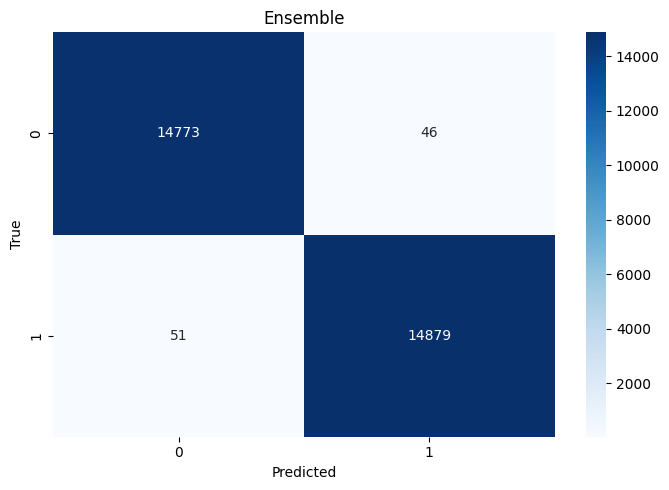

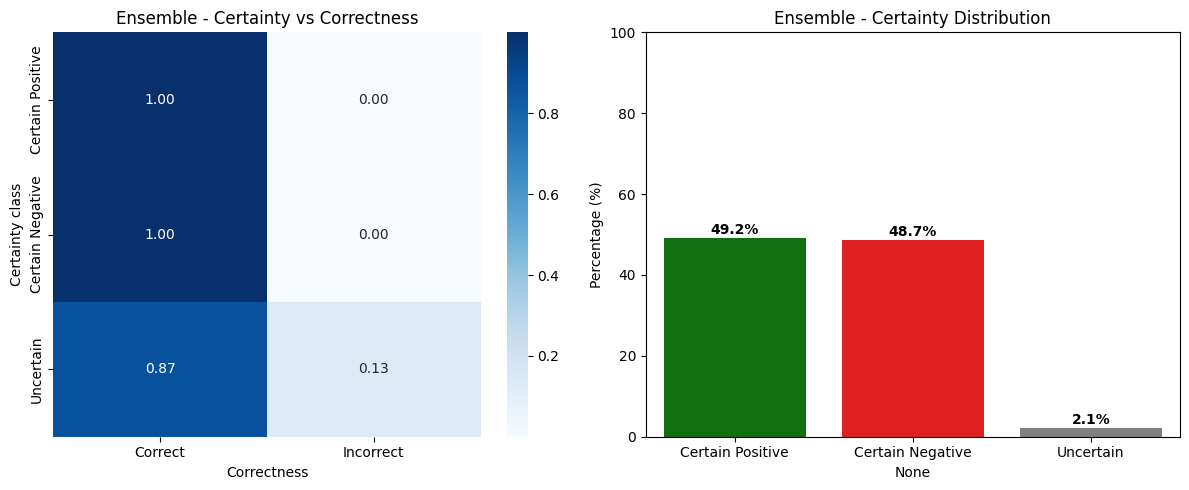

## Ensemble — Unsure Predictions

,probability,true_label,text
0,0.6446,1,"I'm not here to tell you ""Armored"" is Kubricki..."
1,0.5626,1,when i saw the movie at first i thought that i...
2,0.4474,0,My mother took me to this movie at the drive-i...
3,0.3835,0,Eugene O'Neill is acclaimed by some as America...
4,0.6052,1,Brown returned to his role from the year befor...


## Ensemble — Misclassified Predictions

,probability,true_label,predicted,text
0,0.4539,1,0,"I read Angels and Demons about 3 years ago, an..."
1,0.4942,1,0,A fey story of a Martian attempt to colonize E...
2,0.3856,1,0,Forget everything that you have ever read abou...
3,0.5909,0,1,I enjoyed the beautiful scenery in this movie ...
4,0.7067,0,1,"Based on the comments made so far, everyone se..."


## Train/Test Feature Overlap Check

**WARNING:** 29745 identical TF-IDF rows detected in 'all' train/test sets.

**WARNING:** 29744 identical TF-IDF rows detected in 'pos' train/test sets.

**WARNING:** 29743 identical TF-IDF rows detected in 'neg' train/test sets.

**WARNING:** 29746 identical TF-IDF rows detected in 'important' train/test sets.

,train_test_overlap
all,29745
pos,29744
neg,29743
important,29746


In [14]:
results = run_experiment(X_sets_train, y_train, X_sets_train, y_train, train_df["review"], "linear-svm", lower_uncertain=0.3)

LinearSVM 'all' initialized with C=1.0
LinearSVM 'all' trained.


## ALL Evaluation

**Accuracy:** 0.9130

,precision,recall,f1-score,support
0,0.91492,0.90992,0.91241,4940
1,0.91107,0.91601,0.91354,4977
accuracy,0.91298,0.91298,0.91298,0
macro avg,0.91300,0.91297,0.91297,9917
weighted avg,0.91299,0.91298,0.91298,9917


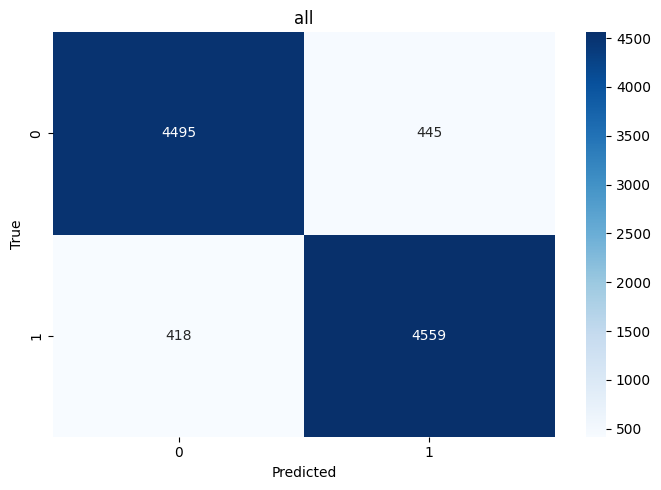

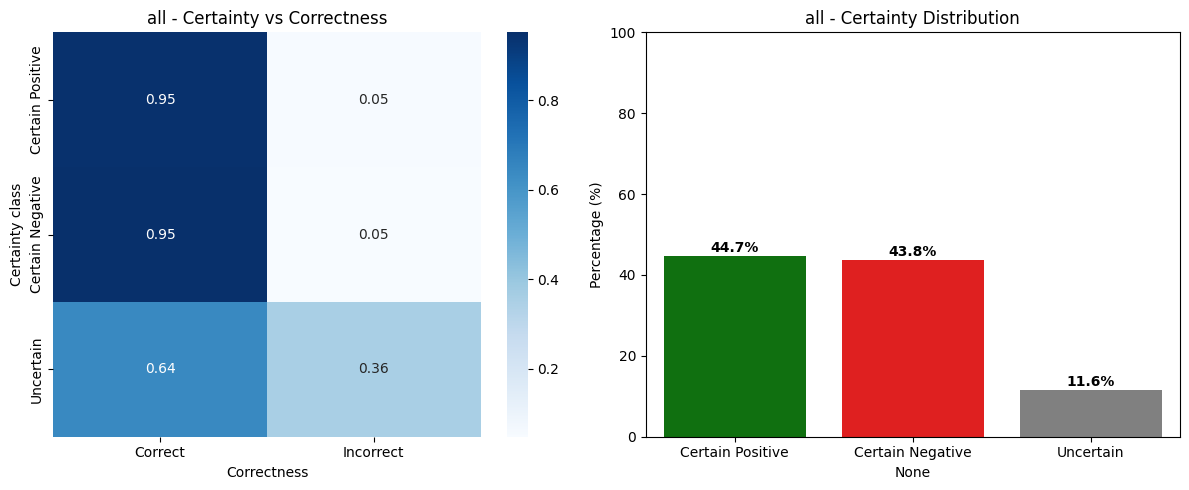

## ALL Model — Unsure Predictions

,probability,true_label,text
0,0.5576,0,What we know of Caravaggio suggests a struttin...
1,0.5644,0,I watched this movie because I like Nicolas Ca...
2,0.6842,1,I've been looking forward to the release of th...
3,0.6189,1,I wasn't sure when I heard about this coming o...
4,0.3777,1,Hard to believe this was directed by Fritz Lan...


## ALL Model — Misclassified Predictions

,probability,true_label,predicted,text
0,0.5576,0,1,What we know of Caravaggio suggests a struttin...
1,0.5644,0,1,I watched this movie because I like Nicolas Ca...
2,0.1875,1,0,This film is to my mind the weakest film in th...
3,0.2721,1,0,"I searched for this movie for years, apparentl..."
4,0.1616,1,0,In the opening scenes of this movie a man shot...


LinearSVM 'pos' initialized with C=1.0
LinearSVM 'pos' trained.


## POS Evaluation

**Accuracy:** 0.8130

,precision,recall,f1-score,support
0,0.80725,0.82065,0.81389,4940
1,0.81900,0.80551,0.81220,4977
accuracy,0.81305,0.81305,0.81305,0
macro avg,0.81312,0.81308,0.81304,9917
weighted avg,0.81315,0.81305,0.81304,9917


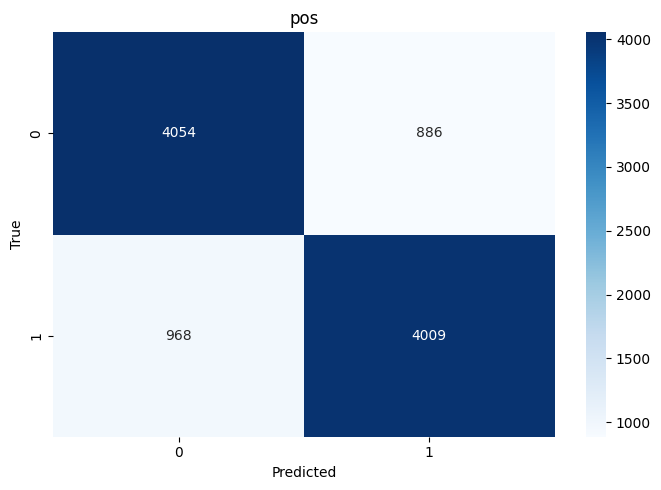

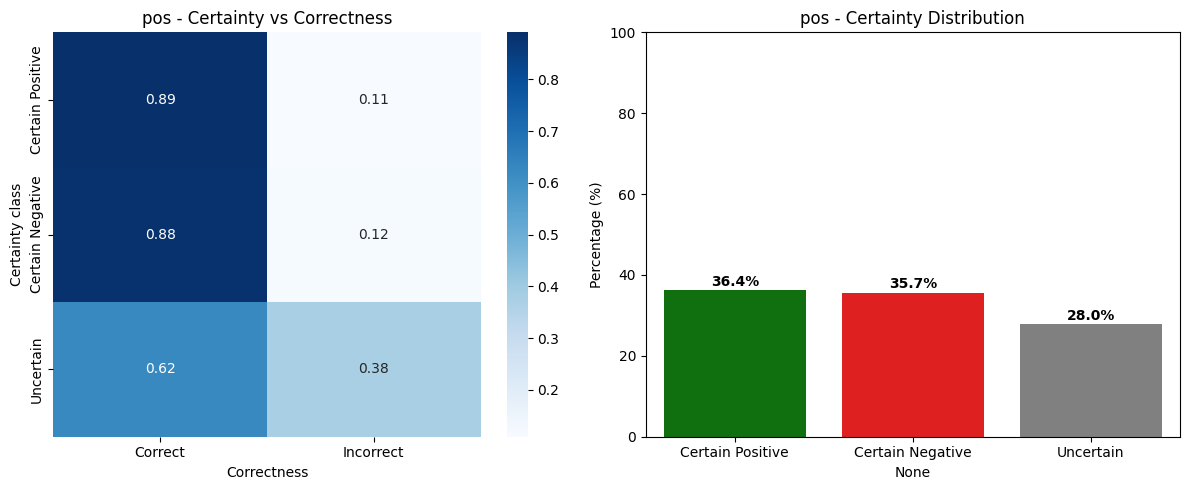

## POS Model — Unsure Predictions

,probability,true_label,text
0,0.4120,0,I am compelled to write a review of this IMAX ...
1,0.3305,1,At the beginning it was almost a shock to see ...
2,0.6734,0,What we know of Caravaggio suggests a struttin...
3,0.5358,1,"If you have ever been, has a friend, or a kid ..."
4,0.3062,1,I find Alan Jacobs review very accurate concer...


## POS Model — Misclassified Predictions

,probability,true_label,predicted,text
0,0.3305,1,0,At the beginning it was almost a shock to see ...
1,0.6734,0,1,What we know of Caravaggio suggests a struttin...
2,0.3062,1,0,I find Alan Jacobs review very accurate concer...
3,0.3820,1,0,"Diane Keaton has played a few ""heavy"" parts in..."
4,0.1033,1,0,I wasn't sure when I heard about this coming o...


LinearSVM 'neg' initialized with C=1.0
LinearSVM 'neg' trained.


## NEG Evaluation

**Accuracy:** 0.8690

,precision,recall,f1-score,support
0,0.87497,0.85992,0.86738,4940
1,0.86330,0.87804,0.87060,4977
accuracy,0.86901,0.86901,0.86901,0
macro avg,0.86913,0.86898,0.86899,9917
weighted avg,0.86911,0.86901,0.86900,9917


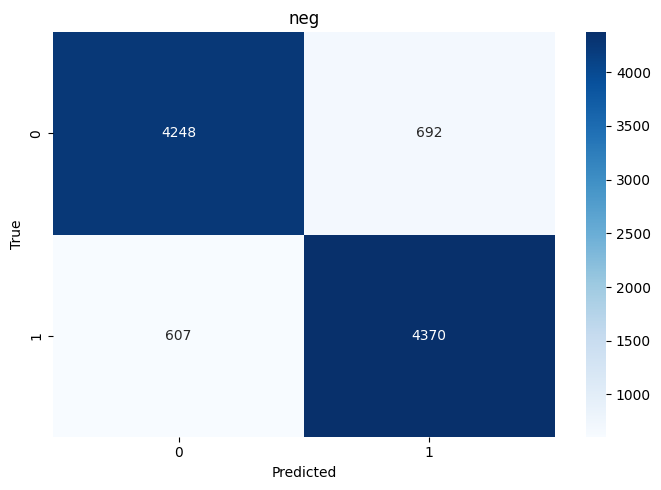

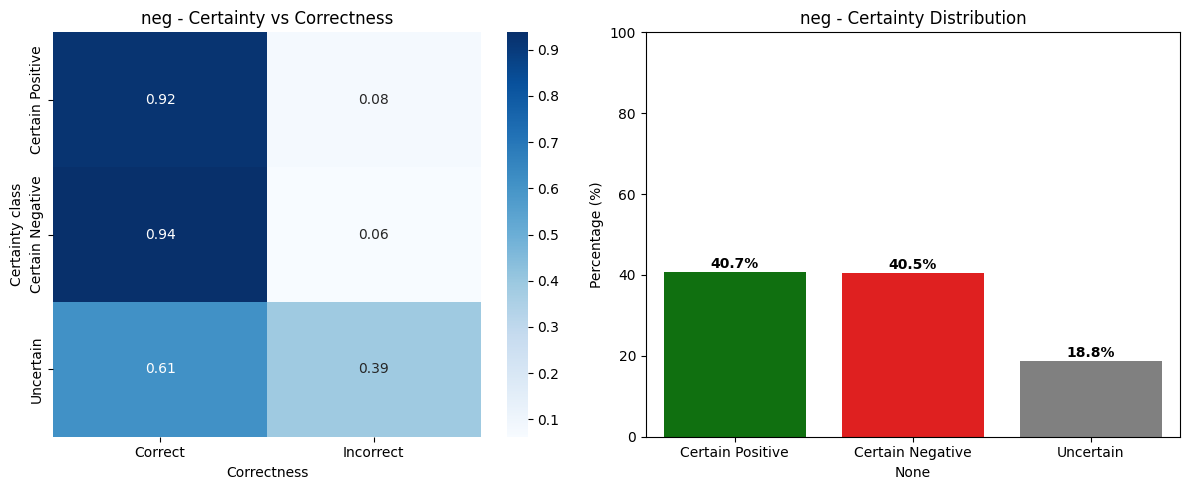

## NEG Model — Unsure Predictions

,probability,true_label,text
0,0.5506,0,This movie treads on very familiar ground -- t...
1,0.5027,0,I watched this movie because I like Nicolas Ca...
2,0.4593,1,I've been looking forward to the release of th...
3,0.3312,1,This film is to my mind the weakest film in th...
4,0.6953,1,As an ex (nuclear) submarine officer I must ad...


## NEG Model — Misclassified Predictions

,probability,true_label,predicted,text
0,0.5506,0,1,This movie treads on very familiar ground -- t...
1,0.5027,0,1,I watched this movie because I like Nicolas Ca...
2,0.4593,1,0,I've been looking forward to the release of th...
3,0.3312,1,0,This film is to my mind the weakest film in th...
4,0.4062,1,0,"I searched for this movie for years, apparentl..."


LinearSVM 'important' initialized with C=1.0
LinearSVM 'important' trained.


## IMPORTANT Evaluation

**Accuracy:** 0.9109

,precision,recall,f1-score,support
0,0.91489,0.90526,0.91005,4940
1,0.90694,0.91642,0.91165,4977
accuracy,0.91086,0.91086,0.91086,0
macro avg,0.91092,0.91084,0.91085,9917
weighted avg,0.91090,0.91086,0.91086,9917


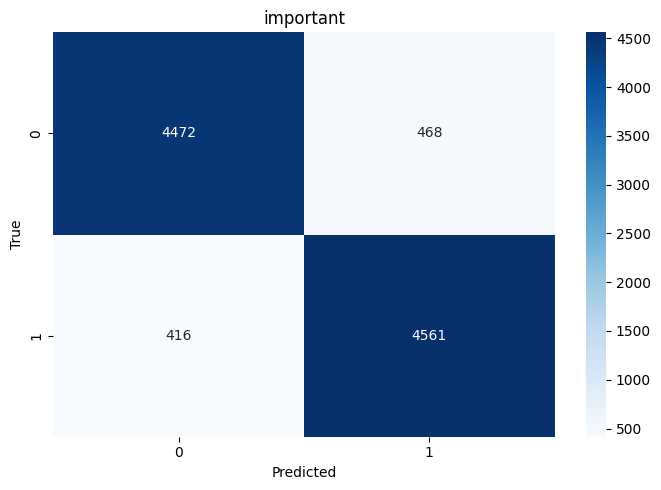

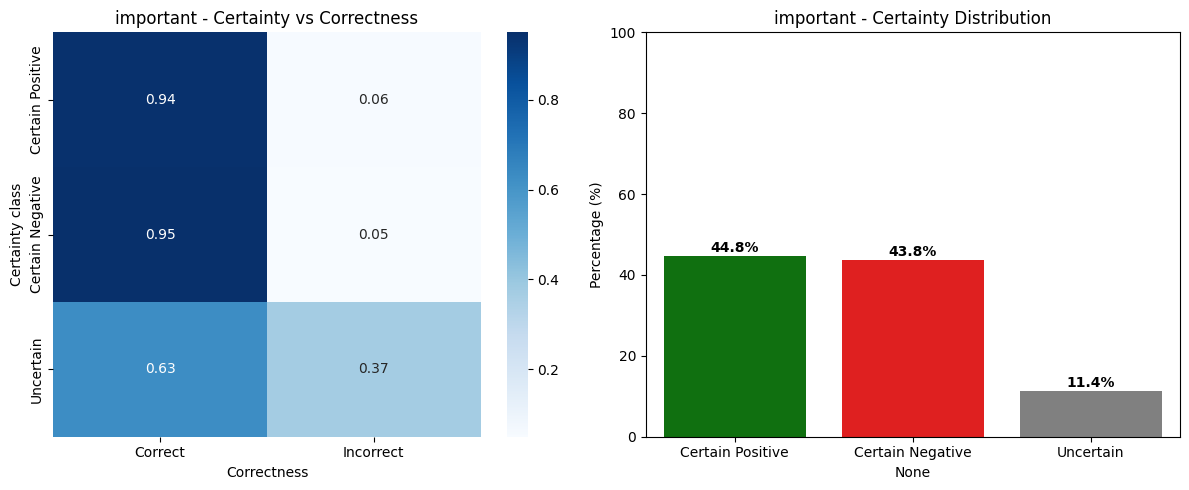

## IMPORTANT Model — Unsure Predictions

,probability,true_label,text
0,0.5574,0,What we know of Caravaggio suggests a struttin...
1,0.5125,0,I watched this movie because I like Nicolas Ca...
2,0.3549,1,I wasn't sure when I heard about this coming o...
3,0.3560,1,Hard to believe this was directed by Fritz Lan...
4,0.4372,0,i saw switching goals ..twice....and always th...


## IMPORTANT Model — Misclassified Predictions

,probability,true_label,predicted,text
0,0.5574,0,1,What we know of Caravaggio suggests a struttin...
1,0.5125,0,1,I watched this movie because I like Nicolas Ca...
2,0.3549,1,0,I wasn't sure when I heard about this coming o...
3,0.1916,1,0,This film is to my mind the weakest film in th...
4,0.2448,1,0,"I searched for this movie for years, apparentl..."


# Ensemble Accuracy: **0.9134**

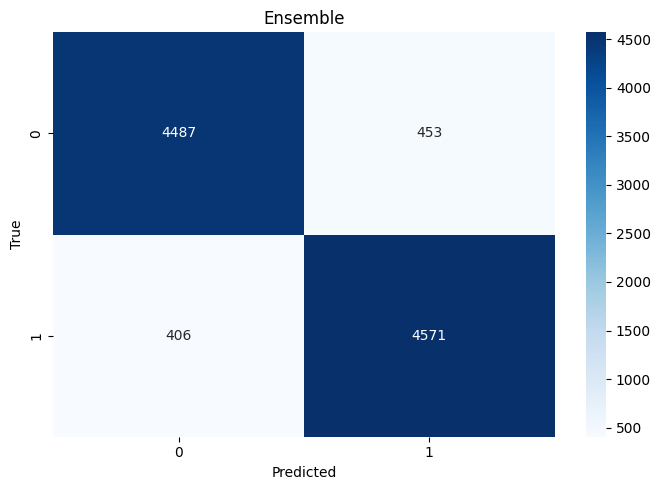

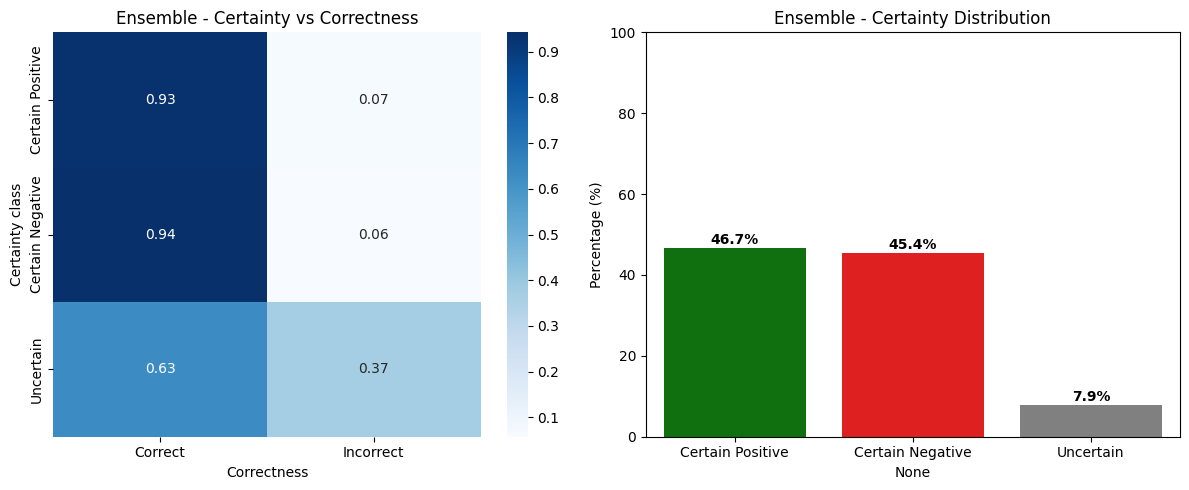

## Ensemble — Unsure Predictions

,probability,true_label,text
0,0.5644,0,I watched this movie because I like Nicolas Ca...
1,0.6189,1,I wasn't sure when I heard about this coming o...
2,0.3777,1,Hard to believe this was directed by Fritz Lan...
3,0.4184,0,i saw switching goals ..twice....and always th...
4,0.6962,1,"A series of vignettes, most of them spoofing t..."


## Ensemble — Misclassified Predictions

,probability,true_label,predicted,text
0,0.5644,0,1,I watched this movie because I like Nicolas Ca...
1,0.1875,1,0,This film is to my mind the weakest film in th...
2,0.2721,1,0,"I searched for this movie for years, apparentl..."
3,0.7189,0,1,I saw this at an arty cinema that was also sho...
4,0.1616,1,0,In the opening scenes of this movie a man shot...


## Train/Test Feature Overlap Check

**WARNING:** 1 identical TF-IDF rows detected in 'all' train/test sets.

**WARNING:** 1 identical TF-IDF rows detected in 'pos' train/test sets.

**WARNING:** 4 identical TF-IDF rows detected in 'neg' train/test sets.

**WARNING:** 1 identical TF-IDF rows detected in 'important' train/test sets.

,train_test_overlap
all,1
pos,1
neg,4
important,1


In [15]:
results = run_experiment(X_sets_train, y_train, X_sets_test, y_test, test_df["review"], "linear-svm", lower_uncertain=0.3)